In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
import datetime as dt
from itertools import chain

## Reflect Tables into SQLALchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect =True)

In [33]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [36]:
inspector = inspect(engine)

In [37]:
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:
first_row_Mment= session.query(Measurement).first()
first_row_Mment.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x13a8573f7f0>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [39]:
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [40]:
first_row_Mment= session.query(Station).first()
first_row_Mment.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x13a86f7ef40>,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'id': 1}

## Bonus Challenge Assignment: Temperature Analysis II

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
start_trip = '2017-08-01'
end_trip = '2017-08-07'
trip=calc_temps('2017-08-01', '2017-08-07')
print(trip)

# for a year in the data set

[(72.0, 79.25, 83.0)]


In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

### Daily Rainfall Average

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


### Daily Temperature Normals

In [45]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip = (calc_temps(start_date,end_date))
print(trip)

# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


[(72.0, 79.25, 83.0)]


In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
columns = [('min','avg','max')]
df = pd.DataFrame(trip,columns = ['min','avg','max'])
df

,min,avg,max
0,72.0,79.25,83.0


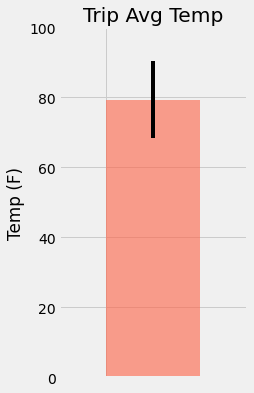

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
error = [df['max']- df['min']]
df.plot(kind='bar', y='avg', yerr=error, color='tomato', alpha=0.6,legend = '',
        figsize=(3,6), title='Trip Avg Temp',align='edge')
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.tick_params(axis='x', which='both', labelbottom=False)
plt.show()

## Close Session

In [49]:
sel = [Station.station, Station.name,Station.latitude,Station.longitude, Station.elevation,func.sum(Measurement.tobs)]
rainfall_station = session.query(*sel).group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= '2015-02-01').\
                    filter(Measurement.date <= '2015-02-14').\
                    order_by(func.sum(Measurement.tobs).desc()).all()
rainfall_station

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 982.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 974.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 947.0),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 908.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 753.0),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 740.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 713.0),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 713.0)]

In [50]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [51]:
start_trip = '2015-02-01'
end_trip = '2015-02-14'

# Use the start and end date to create a range of dates
range_date = pd.date_range(start_trip , end_trip).strftime('%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
range_date_new = pd.date_range(start_trip , end_trip).strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list = []

for date in range_date_new:
    normal = daily_normals(date)
    normal_list.append(normal)
    
print(normal_list)

[[(56.0, 68.14035087719299, 78.0)], [(59.0, 68.85964912280701, 77.0)], [(58.0, 67.79661016949153, 77.0)], [(61.0, 68.14035087719299, 76.0)], [(59.0, 69.6842105263158, 80.0)], [(58.0, 70.38983050847457, 77.0)], [(60.0, 69.0, 77.0)], [(56.0, 66.75438596491227, 74.0)], [(57.0, 67.58928571428571, 75.0)], [(56.0, 68.41666666666667, 76.0)], [(61.0, 69.25, 79.0)], [(60.0, 69.15789473684211, 78.0)], [(58.0, 70.36206896551724, 80.0)], [(62.0, 70.89473684210526, 79.0)]]


In [59]:
new_normal_list = [x for x in chain.from_iterable(normal_list)]
df = pd.DataFrame(new_normal_list, columns = ['tmin','tavg','tmax'],index=[range_date])
df

,tmin,tavg,tmax
2015-02-01,56.0,68.140351,78.0
2015-02-02,59.0,68.859649,77.0
2015-02-03,58.0,67.796610,77.0
2015-02-04,61.0,68.140351,76.0
2015-02-05,59.0,69.684211,80.0
2015-02-06,58.0,70.389831,77.0
2015-02-07,60.0,69.000000,77.0
2015-02-08,56.0,66.754386,74.0
2015-02-09,57.0,67.589286,75.0
2015-02-10,56.0,68.416667,76.0


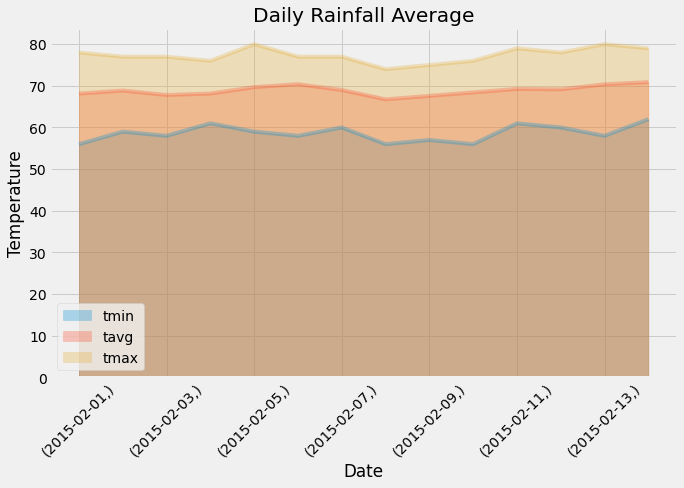

In [60]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind="area", stacked=False, alpha=.3,figsize=(10,6))
plt.title("Daily Rainfall Average")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()